In [67]:
import altair as alt
import calendar
import datetime
import xmlrpc.client
import csv
import pandas as pd
import phonenumbers
import psycopg2

import matplotlib.pyplot as plt

from ast import literal_eval

ODOO_URL = "https://smsperkasa.odoo.com"
ODOO_DB = "smsperkasa-master-1574977"
ODOO_USERNAME = "admin"
ODOO_PASSWORD = "q82fD^YMXL246cUNr2Qp{a{TN"


In [68]:
df = None

In [69]:
def search_from_odoo(model, payload, fields, order=''):
    """Mixin function to search data from Odoo with Odoo's xmlrpc"""
    try:
        common = xmlrpc.client.ServerProxy(f'{ODOO_URL}/xmlrpc/2/common')
        dbname = ODOO_DB
        user = ODOO_USERNAME
        pw = ODOO_PASSWORD

        uid = common.authenticate(dbname, user, pw, {})

        models = xmlrpc.client.ServerProxy(f'{ODOO_URL}/xmlrpc/2/object')
        
        result = models.execute_kw(
            dbname,uid,pw,
            model,'search_read',[payload],
            {
                'fields': fields, 
                'context': {'lang': 'en_GB'}, 
                'order': order
            }
        )

        return result
    except Exception as err:
        return ["Error", err]

def convert_list_str(strList, idx):
    if strList is not None:
        # arrList = literal_eval(strList)
        # return arrList[idx]
        return strList[idx]
    return None

def custom_sort(row):
    if pd.isnull(row['source']):
        return row['create_date']  # If B is None, prioritize create_date
    else:
        return row['create_date'] - datetime.timedelta(weeks=3580)  # If B has a value, prioritize a date in the future

# def convert_phonenumber(phonenumber):
#     """Function to convert phone number to the right format"""
#     if pd.isna(phonenumber) == False:
#         phone = phonenumber
#         res = ''
#         try:
#             res = phonenumbers.format_number(phonenumbers.parse(phone.replace("+69","+62"),"ID"), phonenumbers.PhoneNumberFormat.NATIONAL).replace('0', '+62 ',1)
#         except:
#             # print(phone)
#             res = phonenumbers.format_number(phonenumbers.parse(phone.replace("+","+62"),"ID"), phonenumbers.PhoneNumberFormat.NATIONAL).replace('0', '+62 ',1)
#         return res
#     else:
#         return None

def convert_phonenumber(phonenumber):
    """Function to convert phone number to the right format"""
    try:
        if phonenumber[0] == '0':
            phonenumber = '+62' + phonenumber[1:]
        parsed_phone = phonenumbers.parse(phonenumber, 'ID')
        return phonenumbers.format_number(
            parsed_phone,
            phonenumbers.PhoneNumberFormat.INTERNATIONAL
        )
    except Exception as e:
        if phonenumber is None:
            return None
        return "error"

def reverse_param(feature_param):
    if feature_param == 'cleaned_email':
        return 'cleaned_phone'
    return 'cleaned_email'

def duplicated_label(feature_param, row, depth, label):
    if depth >= 4:
        return None
    found_dup = df[(df[feature_param] == row[feature_param])]
    if len(found_dup) > 1:
        for i, r in found_dup.loc[:, [reverse_param(feature_param)]].iterrows():
            df.loc[(df[reverse_param(feature_param)] == r[reverse_param(feature_param)]), 'group_label'] = label
            duplicated_label(reverse_param(feature_param), r, depth + 1, label)
        df.loc[(df[feature_param] == row[feature_param]), 'group_label'] = label
    return None

def extend_dataframe(param_df, param_list):
    start_date = pd.Timestamp(param_df['date'].max() + datetime.timedelta(days=1))
    end_date = pd.Timestamp('2023-12-31')
    date_range = pd.date_range(start_date, end_date, freq='D')

    extended_data = {'date': date_range}
    for param in param_list:
        extended_data[param] = [None] * len(date_range)
    extended_df = pd.DataFrame(extended_data)

    return pd.concat([param_df, extended_df])

def extend_series(param_series, start_date, end_date):
    complete_date_range = pd.date_range(start=start_date, end=end_date)

    # Convert the index of the Series to a datetime object
    param_series.index = pd.to_datetime(param_series.index)
    # Reindex the Series with the complete date range and fill missing values with 0
    return param_series.reindex(complete_date_range, fill_value=0)


In [70]:
conn = psycopg2.connect(
    host="167.71.206.23",
    database="chatwoot_production",
    user="postgres",
    password="s0f!a_s3xy?!",
)

cursor = conn.cursor()
query = """
SELECT * FROM contacts
WHERE
    (email IS NOT NULL AND email <> '') OR
    (phone_number IS NOT NULL AND phone_number <> '')
ORDER BY id
"""
cursor.execute(query)

records = cursor.fetchall()
cursor.close()

raw_cw_df = pd.DataFrame(records, columns=['id', 'name', 'email', 'phone_number', 'account_id', 'created_at', 'updated_at', 'additional_attributes', 'identifier', 'custom_attributes', 'last_activity_at'])
cw_df = raw_cw_df
cw_df.rename(columns={
    'created_at': 'create_date',
    'phone_number': 'phone',
    'email': 'cleaned_email'
}, inplace=True)
cw_df = cw_df.replace('', None)
cw_df['create_date'] = pd.to_datetime(cw_df['create_date'], errors='coerce')
cw_df['cleaned_phone'] = cw_df.apply(lambda x: convert_phonenumber(x.phone), axis=1)
cw_df = cw_df[cw_df.cleaned_phone != 'error']

In [71]:
odoo_contacts = search_from_odoo(
    'res.partner',
    [
        ['email', 'not like', 'smsperkasa'],
    ],
    ['id', 'name', 'email', 'phone', 'mobile', 'create_date', 'company_type']
)
raw_odoo_contacts_df = pd.DataFrame(odoo_contacts)

odoo_contacts_df = raw_odoo_contacts_df.replace('', None)
odoo_contacts_df = odoo_contacts_df.replace(False, None)
odoo_contacts_df['create_date'] = pd.to_datetime(odoo_contacts_df['create_date'], errors='coerce')

odoo_contacts_df[['phone1', 'phone2', 'phone3']] = odoo_contacts_df['phone'].str.split(r'[,/<>;]+', expand=True)
odoo_contacts_df = odoo_contacts_df.melt(id_vars=['id', 'name', 'email', 'phone', 'mobile', 'create_date', 'company_type'], value_vars=['phone1', 'phone2', 'phone3'], value_name='cleaned_phone')
odoo_contacts_df = odoo_contacts_df[~(((odoo_contacts_df.cleaned_phone.isna()) | (odoo_contacts_df.cleaned_phone.str.strip() == "")) & ((odoo_contacts_df.variable == 'phone2') | (odoo_contacts_df.variable == 'phone3')))]
odoo_contacts_df.drop(columns='variable', inplace=True)

tmp_contact_copy = odoo_contacts_df
work_phones = tmp_contact_copy[['id', 'name', 'email', 'phone', 'create_date', 'company_type', 'cleaned_phone']]
other_phones = (
    tmp_contact_copy[~tmp_contact_copy.mobile.isna()]['mobile'].str.split(',')
    .explode()
    .to_frame('cleaned_phone')
    
    # grab the correct name from the original DataFrame
    .join(tmp_contact_copy[['id', 'name', 'email', 'phone', 'create_date', 'company_type']])
)

tmp_combined_contact = pd.concat([work_phones, other_phones]).reset_index(level=0)
sorted_contacts_df = tmp_combined_contact.sort_values('create_date', ascending=False)
sorted_contacts_df = sorted_contacts_df.drop_duplicates(subset=['id', 'name', 'email', 'phone', 'create_date', 'company_type', 'cleaned_phone'], keep='last')
sorted_contacts_df = sorted_contacts_df[['id', 'name', 'email', 'phone', 'create_date', 'company_type', 'cleaned_phone']]

sorted_contacts_df[['email1', 'email2', 'email3']] = sorted_contacts_df['email'].str.split(r'[ ,/<>]+', expand=True)
sorted_contacts_df = sorted_contacts_df.melt(id_vars=['id', 'name', 'email', 'phone', 'create_date', 'company_type', 'cleaned_phone'], value_vars=['email1', 'email2', 'email3'], value_name='cleaned_email')
sorted_contacts_df = sorted_contacts_df[~(((sorted_contacts_df.cleaned_email.isna()) | (sorted_contacts_df.cleaned_email.str.strip() == "")) & ((sorted_contacts_df.variable == 'email2') | (sorted_contacts_df.variable == 'email3')))]
sorted_contacts_df.drop(columns='variable', inplace=True)

sorted_contacts_df['cleaned_phone'] = sorted_contacts_df.apply(lambda x: convert_phonenumber(x.cleaned_phone), axis=1)

In [72]:
odoo_leads = search_from_odoo(
    'crm.lead',
    [
        "&", "|", ["active", "=", True], ["active", "=", False], ["type", "=", "lead"]
    ],
    ['id', 'name', 'email_from', 'phone', 'create_date', 'type', 'source_id', 'medium_id', 'campaign_id']
)
raw_odoo_leads_df = pd.DataFrame.from_dict(odoo_leads)
odoo_leads_df = raw_odoo_leads_df
odoo_leads_df.rename(columns={
    'email_from': 'cleaned_email'
}, inplace=True)
odoo_leads_df = odoo_leads_df.replace('', None)
odoo_leads_df = odoo_leads_df.replace(False, None)
odoo_leads_df['create_date'] = pd.to_datetime(odoo_leads_df['create_date'], errors='coerce')
odoo_leads_df['cleaned_phone'] = odoo_leads_df.apply(lambda x: convert_phonenumber(x.phone), axis=1)
odoo_leads_df['source'] = odoo_leads_df.apply(lambda x: convert_list_str(x.source_id, 1), axis=1)
odoo_leads_df['medium'] = odoo_leads_df.apply(lambda x: convert_list_str(x.medium_id, 1), axis=1)
odoo_leads_df['campaign'] = odoo_leads_df.apply(lambda x: convert_list_str(x.campaign_id, 1), axis=1)

In [73]:
selected_cw_df = cw_df[['id', 'name', 'cleaned_email', 'cleaned_phone', 'create_date']]
selected_odoo_contacts_df = sorted_contacts_df[['id', 'name', 'cleaned_email', 'cleaned_phone', 'create_date', 'company_type']]
selected_odoo_leads_df = odoo_leads_df[['id', 'name', 'cleaned_email', 'cleaned_phone', 'create_date', 'source', 'medium', 'campaign']]
selected_odoo_leads_df['source'] = selected_odoo_leads_df['source'].fillna(value='direct')

/var/folders/w3/b14k9y695c912pkmbdrg1k900000gn/T/ipykernel_7790/4151903434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_odoo_leads_df['source'] = selected_odoo_leads_df['source'].fillna(value='direct')


In [74]:
joined_contacts = pd.concat([selected_cw_df, selected_odoo_contacts_df, selected_odoo_leads_df])
joined_contacts = joined_contacts[(~joined_contacts.cleaned_email.isna()) | (~joined_contacts.cleaned_phone.isna())]
joined_contacts['cleaned_email'] = joined_contacts['cleaned_email'].str.lower()
joined_contacts = joined_contacts.assign(sort_key=joined_contacts.apply(custom_sort, axis=1))
joined_contacts = joined_contacts.sort_values(by='sort_key', ascending=False)
joined_contacts = joined_contacts.drop_duplicates(subset=['cleaned_email', 'cleaned_phone'], keep='last')

In [75]:
df = joined_contacts
df['group_label'] = None

In [76]:
for index, row in df.iterrows():
    found_dup = df[(df.cleaned_email == row.cleaned_email)]
    if len(found_dup) > 1:
        label = found_dup.reset_index().at[0, 'id']
        duplicated_label('cleaned_email', row, 1, label)

In [77]:
for index, row in df.iterrows():
    found_dup = df[(df.cleaned_phone == row.cleaned_phone)]
    if len(found_dup) > 1:
        label = found_dup.reset_index().at[0, 'id']
        duplicated_label('cleaned_phone', row, 1, label)

In [82]:
copy_df = df.copy()

In [84]:
df = df[df.company_type != 'company']

In [85]:
duplicated_df = df[~df.group_label.isna()]
non_duplicated_df = df[df.group_label.isna()]
filtered_duplicated_df = duplicated_df.drop_duplicates(subset='group_label', keep='last')

In [86]:
filtered_duplicated_df['source'] = filtered_duplicated_df['source'].fillna(value='None')
non_duplicated_df['source'] = non_duplicated_df['source'].fillna(value='None')

filtered_duplicated_df['medium'] = filtered_duplicated_df['medium'].fillna(value='None')
non_duplicated_df['medium'] = non_duplicated_df['medium'].fillna(value='None')

filtered_duplicated_df['campaign'] = filtered_duplicated_df['campaign'].fillna(value='None')
non_duplicated_df['campaign'] = non_duplicated_df['campaign'].fillna(value='None')

/var/folders/w3/b14k9y695c912pkmbdrg1k900000gn/T/ipykernel_7790/1174110423.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_duplicated_df['source'] = filtered_duplicated_df['source'].fillna(value='None')
/var/folders/w3/b14k9y695c912pkmbdrg1k900000gn/T/ipykernel_7790/1174110423.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_duplicated_df['source'] = non_duplicated_df['source'].fillna(value='None')
/var/folders/w3/b14k9y695c912pkmbdrg1k900000gn/T/ipykernel_7790/1174110423.py:4: SettingWi

In [87]:
date_range_2023 = filtered_duplicated_df[(filtered_duplicated_df['create_date'] >= '2023-10-01') & (filtered_duplicated_df['create_date'] <= '2023-12-31')]
filtered_duplicated_mql_2023 = date_range_2023.groupby([date_range_2023['create_date'].dt.date.rename('date')]).agg({'count'})['create_date']

date_range_2023 = non_duplicated_df[(non_duplicated_df['create_date'] >= '2023-10-01') & (non_duplicated_df['create_date'] <= '2023-12-31')]
non_duplicated_mql_2023 = date_range_2023.groupby([date_range_2023['create_date'].dt.date.rename('date')]).agg({'count'})['create_date']

In [88]:
date_range_q3 = filtered_duplicated_df[(filtered_duplicated_df['create_date'] >= '2023-07-01') & (filtered_duplicated_df['create_date'] <= '2023-10-01')]
filtered_duplicated_mql_q3 = date_range_q3.groupby([date_range_q3['create_date'].dt.date.rename('date')]).agg({'count'})['create_date']

date_range_q3 = non_duplicated_df[(non_duplicated_df['create_date'] >= '2023-07-01') & (non_duplicated_df['create_date'] <= '2023-10-01')]
non_duplicated_mql_q3 = date_range_q3.groupby([date_range_q3['create_date'].dt.date.rename('date')]).agg({'count'})['create_date']

In [89]:
mql_target_total = 6000
days_total = 91
mql_daily_target = mql_target_total / days_total

In [90]:
daily_mql = non_duplicated_mql_2023.add(filtered_duplicated_mql_2023, fill_value=0)
daily_mql = daily_mql.reset_index()
daily_mql.rename(columns={
    'count': 'mql'
}, inplace=True)
daily_mql['agg_mql'] = daily_mql['mql'].cumsum()
daily_mql['daily_target'] = mql_daily_target
daily_mql['agg_daily_target'] = daily_mql['daily_target'].cumsum()
daily_mql['daily_percentage'] = daily_mql['agg_mql'] / daily_mql['agg_daily_target'] * 100
daily_mql['mql_target_total'] = mql_target_total
daily_mql['achivement_percentage'] = daily_mql['agg_mql'] / daily_mql['mql_target_total'] * 100

# start_date = pd.Timestamp(daily_mql['date'].max() + datetime.timedelta(days=1))
# end_date = pd.Timestamp('2023-12-31')
# date_range = pd.date_range(start_date, end_date, freq='D')

# extended_data = {'date': date_range, 'mql': [None] * len(date_range), 'agg_mql': [None] * len(date_range), 'daily_target': [None] * len(date_range), 'agg_daily_target': [None] * len(date_range), 'daily_percentage': [None] * len(date_range), 'mql_target_total': [None] * len(date_range), 'achivement_percentage': [None] * len(date_range)}
# extended_df = pd.DataFrame(extended_data)

# daily_mql = pd.concat([daily_mql, extended_df])

daily_mql = extend_dataframe(daily_mql, ['mql', 'agg_mql', 'daily_target', 'agg_daily_target', 'daily_percentage', 'mql_target_total', 'achivement_percentage'])
daily_mql['daily_target'] = mql_daily_target
daily_mql['agg_daily_target'] = daily_mql['daily_target'].cumsum()

daily_mql = daily_mql.sort_values(by='date')

/Users/bcw-003/.virtualenvs/mql-project-dashboard/lib/python3.9/site-packages/pandas/core/sorting.py:417: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  indexer = non_nan_idx[non_nans.argsort(kind=kind)]


In [91]:
daily_mql_q3 = non_duplicated_mql_q3.add(filtered_duplicated_mql_q3, fill_value=0)
daily_mql_q3 = daily_mql_q3.reset_index()
daily_mql_q3.rename(columns={
    'count': 'mql'
}, inplace=True)
daily_mql_q3['agg_mql'] = daily_mql_q3['mql'].cumsum()
agg_mql_q3 = daily_mql_q3.agg_mql.values.tolist()

In [92]:
daily_mql['agg_mql_q3'] = agg_mql_q3
daily_mql['agg_mql_qtd'] = ((daily_mql.agg_mql - daily_mql.agg_mql_q3) / daily_mql.agg_mql_q3) * 100
daily_mql = daily_mql[['date', 'mql', 'agg_mql', 'agg_mql_q3', 'agg_mql_qtd', 'daily_target', 'agg_daily_target', 'daily_percentage', 'mql_target_total', 'achivement_percentage']]

In [108]:
daily_mql

,date,mql,agg_mql,agg_mql_q3,agg_mql_qtd,daily_target,agg_daily_target,daily_percentage,mql_target_total,achivement_percentage
0,2023-10-01,4.0,4.0,27.0,-85.185185,65.934066,65.934066,6.066667,6000,0.066667
1,2023-10-02,75.0,79.0,39.0,102.564103,65.934066,131.868132,59.908333,6000,1.316667
2,2023-10-03,72.0,151.0,101.0,49.50495,65.934066,197.802198,76.338889,6000,2.516667
3,2023-10-04,79.0,230.0,153.0,50.326797,65.934066,263.736264,87.208333,6000,3.833333
4,2023-10-05,80.0,310.0,220.0,40.909091,65.934066,329.670330,94.033333,6000,5.166667
...,...,...,...,...,...,...,...,...,...,...
42,2023-12-27 00:00:00,None,None,5660.0,NaN,65.934066,5802.197802,None,None,None
43,2023-12-28 00:00:00,None,None,5709.0,NaN,65.934066,5868.131868,None,None,None
44,2023-12-29 00:00:00,None,None,5736.0,NaN,65.934066,5934.065934,None,None,None
45,2023-12-30 00:00:00,None,None,5791.0,NaN,65.934066,6000.000000,None,None,None


In [94]:
x = pd.concat([selected_cw_df, selected_odoo_contacts_df, selected_odoo_leads_df])
x = x.assign(sort_key=x.apply(custom_sort, axis=1))
x.sort_values(by='sort_key', ascending=False)

,id,name,cleaned_email,cleaned_phone,create_date,company_type,source,medium,campaign,sort_key
21326,635458,Shop and Cool,shopandcool23@gmail.com,+62 821-3226-4789,2023-11-14 08:12:53.908633,NaN,NaN,NaN,NaN,2023-11-14 08:12:53.908633
0,62739,Tulus Raharjo,tulusraharjo156@gmail.com,+62 859-1883-82662,2023-11-14 08:11:51.000000,person,NaN,NaN,NaN,2023-11-14 08:11:51.000000
21325,635457,Ismi,purchasingkis01@gmail.com,+62 877-8806-2520,2023-11-14 08:08:42.915167,NaN,NaN,NaN,NaN,2023-11-14 08:08:42.915167
2,62737,SAMUDRA INTAN PRATAMA,masnar29@gmail.com,+62 858-9348-2101,2023-11-14 08:00:59.000000,company,NaN,NaN,NaN,2023-11-14 08:00:59.000000
1,62738,regi,masnar29@gmail.com,+62 858-9348-2101,2023-11-14 08:00:59.000000,person,NaN,NaN,NaN,2023-11-14 08:00:59.000000
...,...,...,...,...,...,...,...,...,...,...
21265,12075,ASA Group,None,None,2022-01-03 05:03:23.000000,NaN,direct,None,None,1953-05-25 05:03:23.000000
21266,12070,Pamitra Jaya Konstruksi,None,+62 31 8058143,2022-01-03 04:35:12.000000,NaN,direct,None,None,1953-05-25 04:35:12.000000
21267,12068,Indra Jaya Group,None,None,2022-01-03 04:31:24.000000,NaN,direct,None,None,1953-05-25 04:31:24.000000
21268,12067,Universitas terbuka di merr,None,+62 274 513976,2022-01-03 04:28:25.000000,NaN,direct,None,None,1953-05-25 04:28:25.000000


In [ ]:
x.sort_values(by='sort_key', ascending=False).drop('sort_key', axis=1)

In [62]:
selected_cw_df[selected_cw_df.id == 62723]

,id,name,cleaned_email,cleaned_phone,create_date


In [65]:
selected_odoo_contacts_df[selected_odoo_contacts_df.id == 62706]

,id,name,cleaned_email,cleaned_phone,create_date
22,62706,Adjik,None,+62 823-3966-3216,2023-11-14 03:10:59


In [ ]:
selected_odoo_leads_df[selected_odoo_leads_df.id == ]

In [66]:
x[x.cleaned_phone == '+62 31 3535600'].sort_values('sort_key', ascending=False)

,id,name,cleaned_email,cleaned_phone,create_date,source,medium,campaign,sort_key
4,62722,Angkasa Mesin,None,+62 31 3535600,2023-11-14 06:34:00,NaN,NaN,NaN,2023-11-14 06:34:00


In [104]:
# date_range_2023 = filtered_duplicated_df[(filtered_duplicated_df['create_date'] >= '2023-10-02') & (filtered_duplicated_df['create_date'] <= '2023-10-03')]
date_range_2023 = non_duplicated_df[(non_duplicated_df['create_date'] >= '2023-11-13') & (non_duplicated_df['create_date'] <= '2023-11-14')]
print(len(date_range_2023))
date_range_2023[date_range_2023.medium == 'ppc']

85


,id,name,cleaned_email,cleaned_phone,create_date,company_type,source,medium,campaign,sort_key,group_label
1067,53626,Melianus Kadepa,kadepamelia@gmail.com,+62 822-1703-1661,2023-11-13 19:13:00,NaN,google,ppc,PSC - Display Retargeting ( New ),1955-04-04 19:13:00,None
1070,53623,Septa Dwi anggara,01inaya2022@gmail.com,+62 821-8271-4670,2023-11-13 18:07:38,NaN,google,ppc,PSC - Display Retargeting ( New ),1955-04-04 18:07:38,None
1090,53601,anggi,admin.project@gso.co.id,+62 812-1081-5880,2023-11-13 09:08:56,NaN,google,ppc,Plat Besi Hitam V2.0,1955-04-04 09:08:56,None
1091,53600,Purwanto,poerpurwanto9942@gmail.com,+62 878-5092-8612,2023-11-13 09:04:07,NaN,google,ppc,Sales-Performance Max-1,1955-04-04 09:04:07,None
1092,53599,Alex,andrawahyono0@gmail.com,+62 822-4502-7643,2023-11-13 09:03:34,NaN,google,ppc,Sales-Performance Max-1,1955-04-04 09:03:34,None
1093,53595,Silvi,azizsilvi79@gmail.com,+62 852-5198-4138,2023-11-13 08:41:45,NaN,google,ppc,Sales-Performance Max-1,1955-04-04 08:41:45,None
1094,53594,Jimmy,susantojimmy@hotmail.com,+62 812-1602-4240,2023-11-13 08:29:06,NaN,google,ppc,Plat Besi Hitam V2.0,1955-04-04 08:29:06,None
1096,53592,Irwan,irwand2n76@gmail.com,+62 813-3918-7011,2023-11-13 07:54:21,NaN,google,ppc,Besi Hollow V2.0,1955-04-04 07:54:21,None
1098,53590,Djunaidi,djunaidi150570@gmail.com,+62 813-7225-7742,2023-11-13 07:39:53,NaN,google,ppc,Besi Beton V2.0,1955-04-04 07:39:53,None
1100,53587,Dudi,dudidurahman574@gmail.com,+62 852-8042-0794,2023-11-13 07:30:43,NaN,google,ppc,Sales-Performance Max-1,1955-04-04 07:30:43,None


In [95]:
date_range_2023 = filtered_duplicated_df[(filtered_duplicated_df['create_date'] >= '2023-10-01') & (filtered_duplicated_df['create_date'] <= '2023-12-31')]
source_filtered_duplicated_mql_2023 = date_range_2023.groupby([date_range_2023['create_date'].dt.date.rename('date'), date_range_2023['source']]).agg({'count'})['create_date']
# source_filtered_duplicated_mql_2023 = date_range_2023.groupby([date_range_2023['create_date'].dt.date.rename('date'), 'source'])['create_date'].count()
# source_filtered_duplicated_mql_2023 = date_range_2023.groupby([['create_date', 'source']])['create_date'].count()
# source_filtered_duplicated_mql_2023 = date_range_2023.groupby([[date_range_2023['create_date'].dt.date.rename('date'), date_range_2023['source']]]).agg({'count'})['create_date']
# source_filtered_duplicated_mql_2023
date_range_2023 = non_duplicated_df[(non_duplicated_df['create_date'] >= '2023-10-01') & (non_duplicated_df['create_date'] <= '2023-12-31')]
source_non_duplicated_mql_2023 = date_range_2023.groupby([date_range_2023['create_date'].dt.date.rename('date'), date_range_2023['source']]).agg({'count'})['create_date']

In [96]:
source_non_duplicated_mql_2023.add(source_filtered_duplicated_mql_2023, fill_value=0)

count
date       source       
2023-10-01 direct    1.0
           google    3.0
2023-10-02 None     15.0
           direct   19.0
           google   41.0
...                  ...
2023-11-13 direct   17.0
           google   64.0
2023-11-14 None     10.0
           direct   16.0
           google   40.0

[130 rows x 1 columns]

In [97]:
source_filtered_duplicated_mql_2023

count
date       source       
2023-10-01 direct      1
           google      3
2023-10-02 None        2
           direct      1
           google     18
...                  ...
2023-11-13 direct      3
           google      9
2023-11-14 None        2
           direct      1
           google     15

[118 rows x 1 columns]

In [98]:
source_non_duplicated_mql_2023

count
date       source       
2023-10-02 None       13
           direct     18
           google     23
2023-10-03 None       17
           direct     12
...                  ...
2023-11-13 direct     14
           google     55
2023-11-14 None        8
           direct     15
           google     25

[119 rows x 1 columns]

In [99]:
source_daily_mql = source_non_duplicated_mql_2023.add(source_filtered_duplicated_mql_2023, fill_value=0)
source_daily_mql = source_daily_mql.reset_index()
source_daily_mql.rename(columns={
    'count': 'mql'
}, inplace=True)
source_daily_mql

,date,source,mql
0,2023-10-01,direct,1.0
1,2023-10-01,google,3.0
2,2023-10-02,None,15.0
3,2023-10-02,direct,19.0
4,2023-10-02,google,41.0
...,...,...,...
125,2023-11-13,direct,17.0
126,2023-11-13,google,64.0
127,2023-11-14,None,10.0
128,2023-11-14,direct,16.0


In [105]:
source_daily_mql.mql.sum()

2663.0

In [100]:
source_daily_mql.to_csv('./data/source_daily_mql.csv', index=False)
source_daily_mql = pd.read_csv('data/source_daily_mql.csv')

In [101]:
alt.Chart(source_daily_mql).mark_bar().encode(
    x=alt.X("date:N"),
    xOffset="source:N",
    y=alt.Y("mql:Q"),
    color=alt.Color("source:N"),
).interactive()

alt.Chart(...)

In [53]:
date_range_2023 = filtered_duplicated_df[(filtered_duplicated_df['create_date'] >= '2023-10-01') & (filtered_duplicated_df['create_date'] <= '2023-12-31')]
medium_filtered_duplicated_mql_2023 = date_range_2023.groupby([date_range_2023['create_date'].dt.date.rename('date'), date_range_2023['medium']]).agg({'count'})['create_date']
date_range_2023 = non_duplicated_df[(non_duplicated_df['create_date'] >= '2023-10-01') & (non_duplicated_df['create_date'] <= '2023-12-31')]
medium_non_duplicated_mql_2023 = date_range_2023.groupby([date_range_2023['create_date'].dt.date.rename('date'), date_range_2023['medium']]).agg({'count'})['create_date']

In [54]:
medium_daily_mql = medium_non_duplicated_mql_2023.add(medium_filtered_duplicated_mql_2023, fill_value=0)
medium_daily_mql = medium_daily_mql.reset_index()
medium_daily_mql.rename(columns={
    'count': 'mql'
}, inplace=True)
medium_daily_mql

,date,medium,mql
0,2023-10-01,None,3.0
1,2023-10-01,ppc,1.0
2,2023-10-02,None,45.0
3,2023-10-02,ppc,30.0
4,2023-10-03,None,49.0
...,...,...,...
83,2023-11-12,ppc,5.0
84,2023-11-13,None,67.0
85,2023-11-13,ppc,39.0
86,2023-11-14,None,45.0


In [55]:
medium_daily_mql.to_csv('./data/medium_daily_mql.csv', index=False)
medium_daily_mql = pd.read_csv('data/medium_daily_mql.csv')

alt.Chart(medium_daily_mql).mark_bar().encode(
    x=alt.X("date:N"),
    xOffset="medium:N",
    y=alt.Y("mql:Q"),
    color=alt.Color("medium:N"),
).interactive()

alt.Chart(...)

In [56]:
date_range_2023 = filtered_duplicated_df[(filtered_duplicated_df['create_date'] >= '2023-10-01') & (filtered_duplicated_df['create_date'] <= '2023-12-31')]
campaign_filtered_duplicated_mql_2023 = date_range_2023.groupby([date_range_2023['create_date'].dt.date.rename('date'), date_range_2023['campaign']]).agg({'count'})['create_date']
date_range_2023 = non_duplicated_df[(non_duplicated_df['create_date'] >= '2023-10-01') & (non_duplicated_df['create_date'] <= '2023-12-31')]
campaign_non_duplicated_mql_2023 = date_range_2023.groupby([date_range_2023['create_date'].dt.date.rename('date'), date_range_2023['campaign']]).agg({'count'})['create_date']

In [57]:
campaign_daily_mql = campaign_non_duplicated_mql_2023.add(campaign_filtered_duplicated_mql_2023, fill_value=0)
campaign_daily_mql = campaign_daily_mql.reset_index()
campaign_daily_mql.rename(columns={
    'count': 'mql'
}, inplace=True)
campaign_daily_mql

,date,campaign,mql
0,2023-10-01,Besi Hollow V2.0,1.0
1,2023-10-01,None,1.0
2,2023-10-01,PSC - Besi Siku,1.0
3,2023-10-01,Sales-Performance Max-1,1.0
4,2023-10-02,Besi Beton V2.0,3.0
...,...,...,...
306,2023-11-14,None,28.0
307,2023-11-14,PSC - Besi Siku,3.0
308,2023-11-14,Plat Besi Hitam V2.0,3.0
309,2023-11-14,Sales-Performance Max-1,11.0


In [58]:
campaign_daily_mql.to_csv('./data/campaign_daily_mql.csv', index=False)
campaign_daily_mql = pd.read_csv('data/campaign_daily_mql.csv')

alt.Chart(campaign_daily_mql).mark_bar().encode(
    x=alt.X("date:N"),
    xOffset="campaign:N",
    y=alt.Y("mql:Q"),
    color=alt.Color("campaign:N"),
).interactive()

alt.Chart(...)

In [19]:
start_date = '2023-10-01'
end_date = '2023-12-31'

date_range = pd.date_range(start=start_date, end=end_date, freq='D')
date_array = date_range.date
x_axis = date_array.tolist()

y_axis_actual = daily_mql.agg_mql.values.tolist()
y_axis_qtd = daily_mql.agg_mql_q3.values.tolist()
y_axis_target = daily_mql.agg_daily_target.values.tolist()

# y_axis_actual = []
# for data in daily_mql.values:
#     try:
#         y_axis_actual.append(data[2])
#     except:
#         y_axis_actual.append(None)

# y_axis_qtd = []
# for data in daily_mql.values:
#     try:
#         y_axis_qtd.append(data[4])
#     except:
#         y_axis_qtd.append(None)

# y_axis_target = []
# for data in daily_mql.values:
#     try:
#         y_axis_target.append(data[6])
#     except:
#         y_axis_target.append(None)

# desired_length = len(x_axis)
# num_zeros = max(0, desired_length - len(y_axis_actual))
# y_axis_actual = y_axis_actual + [0] * num_zeros

# num_zeros = max(0, desired_length - len(y_axis_target))
# y_axis_target = y_axis_target + [0] * num_zeros

Google Analytics Data

In [20]:
conn = psycopg2.connect(
    host="178.128.83.235",
    database="warehouse_db",
    user="postgres",
    password="s0f!a_s3xy?!",
)

cursor = conn.cursor()
query = """
SELECT uuid, date, unifiedpagepathscreen, engagedsessions, sessions, conversions, totalusers, engagementrate, userconversionrate, activeusers, userengagementduration, screenpageviews 
FROM g_analytics.pages_and_screens_____path_and_screen_class
WHERE
    unifiedpagepathscreen LIKE '/produk/%'
"""
cursor.execute(query)

g_anal_records = cursor.fetchall()
cursor.close()

In [21]:
raw_ga_df = pd.DataFrame(g_anal_records, columns=['uuid', 'date', 'unifiedpagepathscreen', 'engagedsessions', 'sessions', 'conversions', 'totalusers', 'engagementrate', 'userconversionrate', 'activeusers', 'userengagementduration', 'screenpageviews'])
raw_ga_df['date'] = pd.to_datetime(raw_ga_df['date'], format='%Y%m%d')

In [22]:
ga_df = raw_ga_df[(raw_ga_df['date'] >= '2023-10-01') & (raw_ga_df['date'] <= '2023-12-31')]
ga_q3_df = raw_ga_df[(raw_ga_df['date'] >= '2023-07-01') & (raw_ga_df['date'] < '2023-10-01')]

In [23]:
engaged_sessions = ga_df.groupby('date')['engagedsessions'].sum()
sessions = ga_df.groupby('date')['sessions'].sum()

conversions = ga_df.groupby('date')['conversions'].sum()
totalusers = ga_df.groupby('date')['totalusers'].sum()


engaged_sessions_q3 = ga_q3_df.groupby('date')['engagedsessions'].sum()
sessions_q3 = ga_q3_df.groupby('date')['sessions'].sum()

conversions_q3 = ga_q3_df.groupby('date')['conversions'].sum()
totalusers_q3 = ga_q3_df.groupby('date')['totalusers'].sum()

start_date = datetime.date(2023, 7, 1)
end_date = datetime.date(2023, 9, 30)

engaged_sessions_q3 = extend_series(engaged_sessions_q3, start_date, end_date)
sessions_q3 = extend_series(sessions_q3, start_date, end_date)
conversions_q3 = extend_series(conversions_q3, start_date, end_date)
totalusers_q3 = extend_series(totalusers_q3, start_date, end_date)

In [24]:
daily_engagement_rate = engaged_sessions.divide(sessions, fill_value=0)
daily_conversion_rate = conversions.cumsum().divide(totalusers.cumsum(), fill_value=0)

daily_engagement_rate = daily_engagement_rate.reset_index(name='engagement_rate')
daily_conversion_rate = daily_conversion_rate.reset_index(name='conversion_rate')

daily_engagement_rate['engagement_rate'] = daily_engagement_rate['engagement_rate'] * 100
daily_conversion_rate['conversion_rate'] = daily_conversion_rate['conversion_rate'] * 100

daily_engagement_rate = extend_dataframe(daily_engagement_rate, ['engagement_rate', 'target'])
daily_conversion_rate = extend_dataframe(daily_conversion_rate, ['conversion_rate', 'target'])

daily_engagement_rate['initial'] = 55.47
daily_conversion_rate['initial'] = 1.18

daily_engagement_rate['target'] = 61.01
daily_conversion_rate['target'] = 1.298

daily_engagement_rate_q3 = engaged_sessions_q3.divide(sessions_q3, fill_value=0)
daily_conversion_rate_q3 = conversions_q3.cumsum().divide(totalusers_q3.cumsum(), fill_value=0)

daily_engagement_rate_q3 = daily_engagement_rate_q3.reset_index(name='engagement_rate_q3')
daily_conversion_rate_q3 = daily_conversion_rate_q3.reset_index(name='conversion_rate_q3')

daily_engagement_rate['engagement_rate_q3'] = daily_engagement_rate_q3.engagement_rate_q3.values.tolist()
daily_conversion_rate['conversion_rate_q3'] = daily_conversion_rate_q3.conversion_rate_q3.values.tolist()

daily_engagement_rate['engagement_rate_q3'] = daily_engagement_rate['engagement_rate_q3'] * 100
daily_conversion_rate['conversion_rate_q3'] = daily_conversion_rate['conversion_rate_q3'] * 100

daily_engagement_rate['engagement_rate_qtd'] = ((daily_engagement_rate.engagement_rate - daily_engagement_rate.engagement_rate_q3) / daily_engagement_rate.engagement_rate_q3) * 100
daily_conversion_rate['conversion_rate_qtd'] = ((daily_conversion_rate.conversion_rate - daily_conversion_rate.conversion_rate_q3) / daily_conversion_rate.conversion_rate_q3) * 100

daily_engagement_rate['daily_percentage'] = ((daily_engagement_rate.engagement_rate - daily_engagement_rate.initial) / (daily_engagement_rate.target - daily_engagement_rate.initial)) * 100
daily_conversion_rate['daily_percentage'] = ((daily_conversion_rate.conversion_rate - daily_conversion_rate.initial) / (daily_conversion_rate.target - daily_conversion_rate.initial)) * 100

In [25]:
y_axis_engagement_actual = daily_engagement_rate.engagement_rate.values.tolist()
y_axis_engagement_qtd = daily_engagement_rate.engagement_rate_q3.values.tolist()
y_axis_engagement_target = daily_engagement_rate.target.values.tolist()
y_axis_engagement_initial = daily_engagement_rate.initial.values.tolist()

y_axis_conversion_actual = daily_conversion_rate.conversion_rate.values.tolist()
y_axis_conversion_qtd = daily_conversion_rate.conversion_rate_q3.values.tolist()
y_axis_conversion_target = daily_conversion_rate.target.values.tolist()
y_axis_conversion_initial = daily_conversion_rate.initial.values.tolist()

# desired_length = len(x_axis)
# num_zeros = max(0, desired_length - len(y_axis_engagement_actual))
# y_axis_engagement_actual = y_axis_engagement_actual + [None] * num_zeros

# num_zeros = max(0, desired_length - len(y_axis_engagement_target))
# y_axis_engagement_target = y_axis_engagement_target + [61.01] * num_zeros

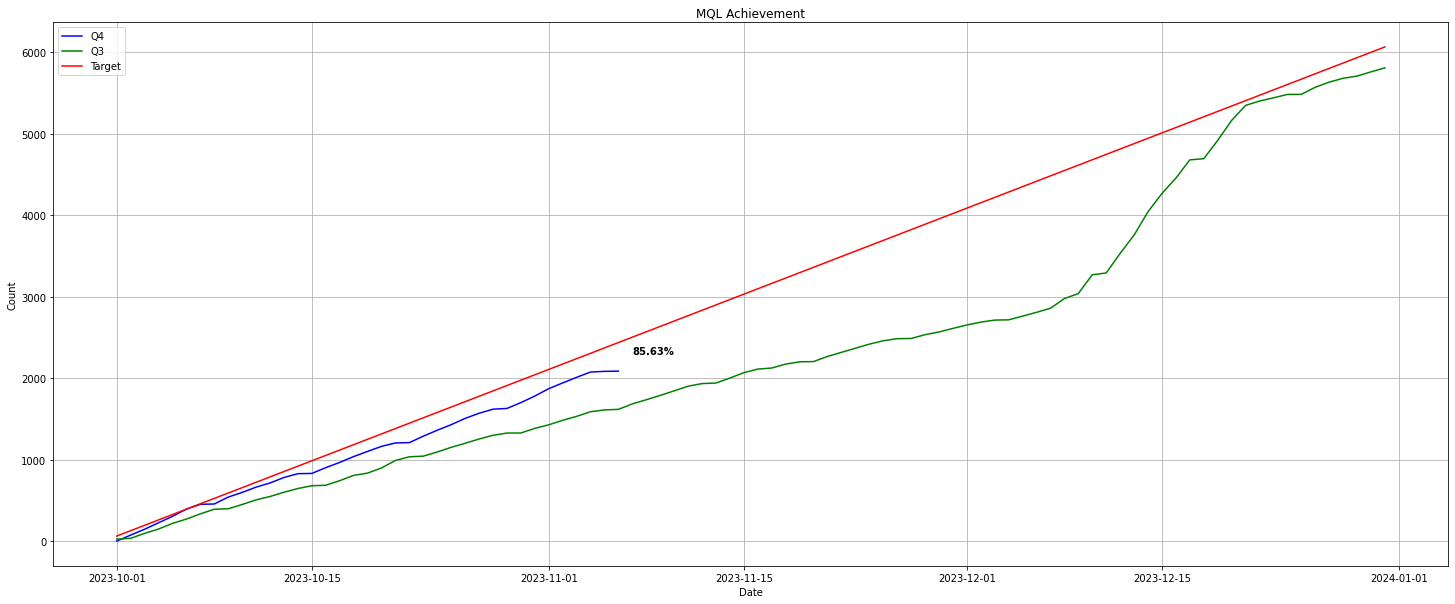

In [26]:
annotation_date = pd.to_datetime(datetime.date.today() + datetime.timedelta(days=1))
plt.figure(figsize=(25,10))
plt.title("MQL Achievement")
plt.grid()
plt.plot(x_axis,y_axis_actual, label="Q4", color='b')

plt.plot(x_axis,y_axis_qtd, label="Q3", color='g')

plt.plot(x_axis,y_axis_target, label="Target", color='r')

improvements = "{:.2f}%".format(daily_mql[~daily_mql.mql.isna()].tail(1).daily_percentage.values[0])

current_mql = daily_mql[~daily_mql.mql.isna()].tail(1).agg_mql.values[0]

plt.annotate(improvements, 
    xy=(annotation_date, current_mql + 0.1 * current_mql), xycoords='data',
    xytext=(0, 0), textcoords='offset points', color='black', weight='bold', size=10)

plt.xlabel("Date")
plt.ylabel("Count")
plt.legend()
plt.show()

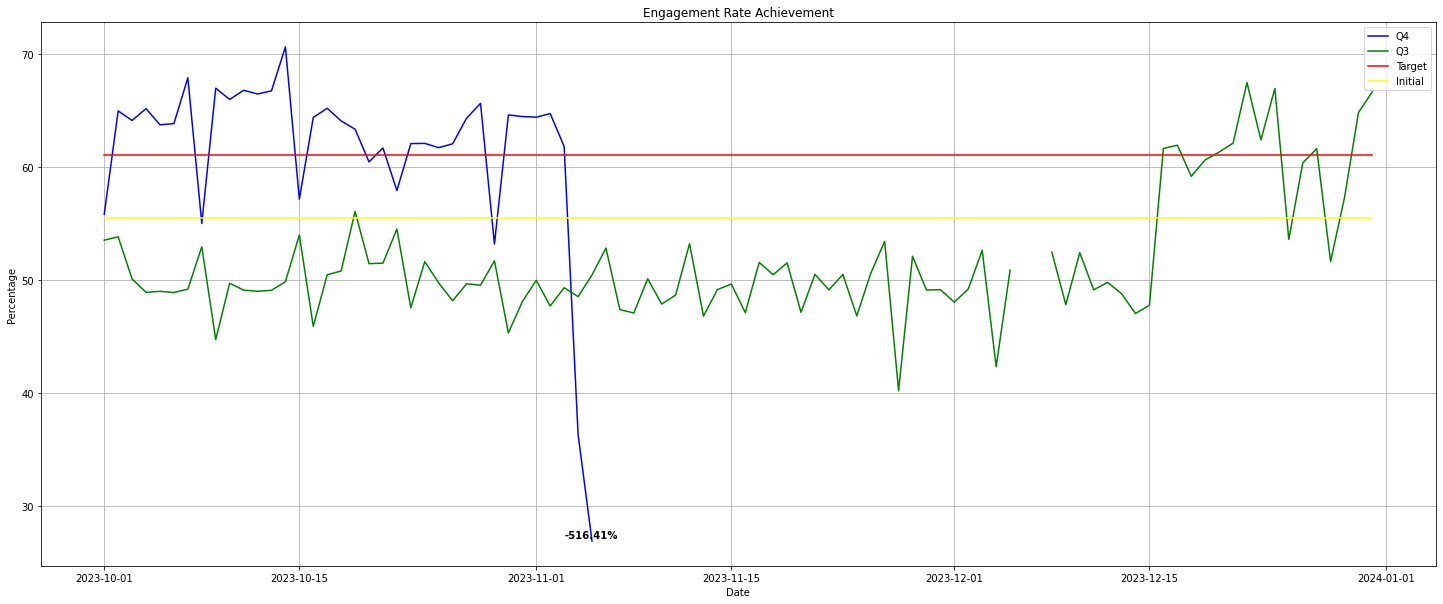

In [27]:
annotation_date = pd.to_datetime('2023-11-03')
plt.figure(figsize=(25,10))
plt.title("Engagement Rate Achievement")
plt.grid()
plt.plot(x_axis,y_axis_engagement_actual, label="Q4", color='b')

plt.plot(x_axis,y_axis_engagement_qtd, label="Q3", color='g')

plt.plot(x_axis,y_axis_engagement_target, label="Target", color='r')

plt.plot(x_axis,y_axis_engagement_initial, label="Initial", color='yellow')

improvements = "{:.2f}%".format(daily_engagement_rate[~daily_engagement_rate.engagement_rate.isna()].tail(1).daily_percentage.values[0])

current_value = daily_engagement_rate[~daily_engagement_rate.engagement_rate.isna()].tail(1).engagement_rate.values[0]

plt.annotate(improvements, 
    xy=(annotation_date, current_value + 0.01 * current_value), xycoords='data',
    xytext=(0, 0), textcoords='offset points', color='black', weight='bold', size=10)

plt.xlabel("Date")
plt.ylabel("Percentage")
plt.legend()
plt.show()

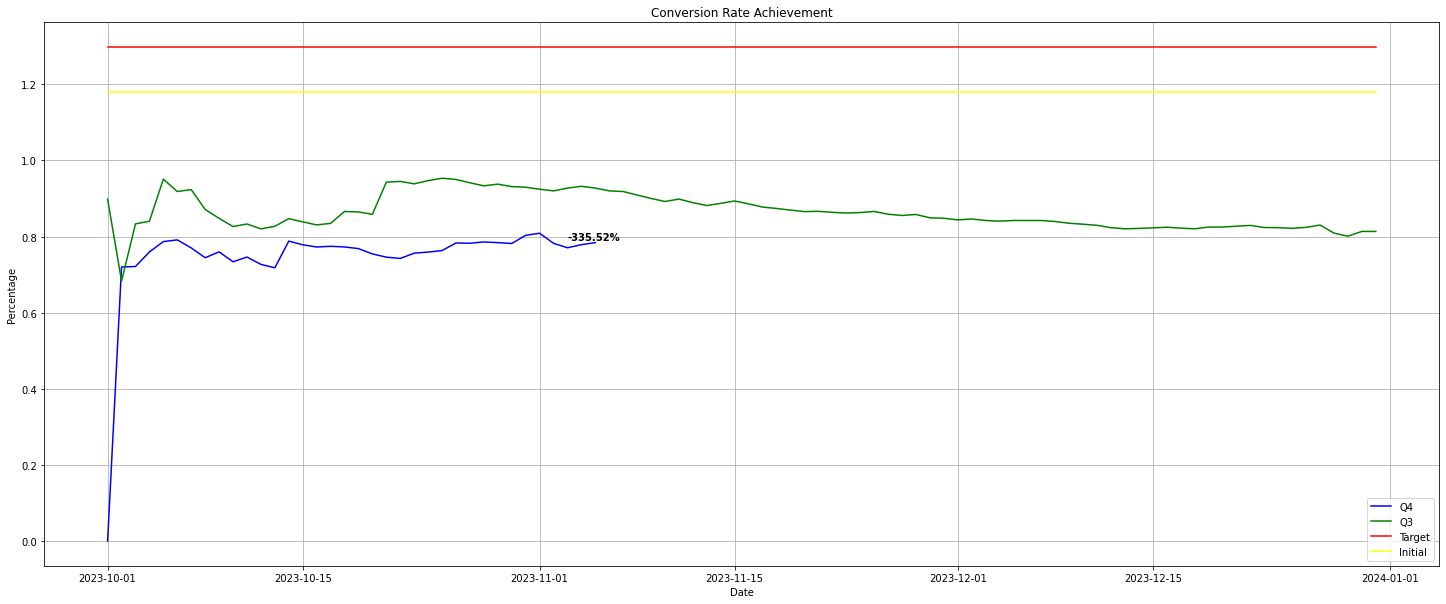

In [28]:
plt.figure(figsize=(25,10))
plt.title("Conversion Rate Achievement")
plt.grid()
plt.plot(x_axis,y_axis_conversion_actual, label="Q4", color='b')

plt.plot(x_axis,y_axis_conversion_qtd, label="Q3", color='g')

plt.plot(x_axis,y_axis_conversion_target, label="Target", color='r')

plt.plot(x_axis,y_axis_conversion_initial, label="Initial", color='yellow')

improvements = "{:.2f}%".format(daily_conversion_rate[~daily_conversion_rate.conversion_rate.isna()].tail(1).daily_percentage.values[0])

current_value = daily_conversion_rate[~daily_conversion_rate.conversion_rate.isna()].tail(1).conversion_rate.values[0]

plt.annotate(improvements, 
    xy=(annotation_date, current_value + 0.01 * current_value), xycoords='data',
    xytext=(0, 0), textcoords='offset points', color='black', weight='bold', size=10)

plt.xlabel("Date")
plt.ylabel("Percentage")
plt.legend()
plt.show()

In [29]:
daily_mql[~daily_mql.mql.isna()]

,date,mql,agg_mql,agg_mql_q3,agg_mql_qtd,daily_target,agg_daily_target,daily_percentage,mql_target_total,achivement_percentage
0,2023-10-01,4.0,4.0,28.0,-85.714286,65.934066,65.934066,6.066667,6000,0.066667
1,2023-10-02,74.0,78.0,38.0,105.263158,65.934066,131.868132,59.15,6000,1.3
2,2023-10-03,71.0,149.0,99.0,50.505051,65.934066,197.802198,75.327778,6000,2.483333
3,2023-10-04,80.0,229.0,152.0,50.657895,65.934066,263.736264,86.829167,6000,3.816667
4,2023-10-05,78.0,307.0,221.0,38.914027,65.934066,329.670330,93.123333,6000,5.116667
5,2023-10-06,90.0,397.0,274.0,44.890511,65.934066,395.604396,100.352778,6000,6.616667
6,2023-10-07,58.0,455.0,338.0,34.615385,65.934066,461.538462,98.583333,6000,7.583333
7,2023-10-08,4.0,459.0,395.0,16.202532,65.934066,527.472527,87.01875,6000,7.65
8,2023-10-09,85.0,544.0,400.0,36.0,65.934066,593.406593,91.674074,6000,9.066667
9,2023-10-10,57.0,601.0,453.0,32.671082,65.934066,659.340659,91.151667,6000,10.016667


In [30]:
daily_engagement_rate[~daily_engagement_rate.engagement_rate.isna()]

,date,engagement_rate,target,initial,engagement_rate_q3,engagement_rate_qtd,daily_percentage
0,2023-10-01,55.775578,61.01,55.47,53.493450,4.266182,5.51584
1,2023-10-02,64.932615,61.01,55.47,53.787879,20.71979,170.805317
2,2023-10-03,64.089258,61.01,55.47,50.057241,28.031942,155.582273
3,2023-10-04,65.136549,61.01,55.47,48.876236,33.26834,174.486435
4,2023-10-05,63.704819,61.01,55.47,48.965919,30.100324,148.642947
5,2023-10-06,63.807938,61.01,55.47,48.858711,30.59685,150.504293
6,2023-10-07,67.865391,61.01,55.47,49.158576,38.054021,223.743519
7,2023-10-08,54.966887,61.01,55.47,52.908068,3.891316,-9.081455
8,2023-10-09,66.943651,61.01,55.47,44.694534,49.780399,207.105614
9,2023-10-10,65.949119,61.01,55.47,49.681529,32.74374,189.153779


In [31]:
daily_conversion_rate[~daily_conversion_rate.conversion_rate.isna()]

,date,conversion_rate,target,initial,conversion_rate_q3,conversion_rate_qtd,daily_percentage
0,2023-10-01,0.0,1.298,1.18,0.898204,-100.0,-1000.0
1,2023-10-02,0.719979,1.298,1.18,0.682982,5.416988,-389.847941
2,2023-10-03,0.721187,1.298,1.18,0.833205,-13.444258,-388.824953
3,2023-10-04,0.759469,1.298,1.18,0.840065,-9.593939,-356.381921
4,2023-10-05,0.786694,1.298,1.18,0.950742,-17.254749,-333.310475
5,2023-10-06,0.791111,1.298,1.18,0.918219,-13.842936,-329.56731
6,2023-10-07,0.770026,1.298,1.18,0.923267,-16.59775,-347.435729
7,2023-10-08,0.744293,1.298,1.18,0.870938,-14.541244,-369.243287
8,2023-10-09,0.759677,1.298,1.18,0.847752,-10.389171,-356.205635
9,2023-10-10,0.733636,1.298,1.18,0.826196,-11.2031,-378.27418


In [16]:
import altair as alt
import pandas as pd
import streamlit as st
from vega_datasets import data

st.set_page_config(
    page_title="Time series annotations", page_icon="⬇", layout="centered"
)


@st.cache_data
def get_data():
    source = data.stocks()
    source = source[source.date.gt("2004-01-01")]
    return source


@st.cache_data(ttl=60 * 60 * 24)
def get_chart(data):
    hover = alt.selection_single(
        fields=["date"],
        nearest=True,
        on="mouseover",
        empty="none",
    )

    lines = (
        alt.Chart(data, height=500, title="Evolution of stock prices")
        .mark_line()
        .encode(
            x=alt.X("date", title="Date"),
            y=alt.Y("price", title="Price"),
            color="symbol",
        )
    )

    # Draw points on the line, and highlight based on selection
    points = lines.transform_filter(hover).mark_circle(size=65)

    # Draw a rule at the location of the selection
    tooltips = (
        alt.Chart(data)
        .mark_rule()
        .encode(
            x="yearmonthdate(date)",
            y="price",
            opacity=alt.condition(hover, alt.value(0.3), alt.value(0)),
            tooltip=[
                alt.Tooltip("date", title="Date"),
                alt.Tooltip("price", title="Price (USD)"),
            ],
        )
        .add_selection(hover)
    )

    return (lines + points + tooltips).interactive()


st.title("⬇ Time series annotations")

st.write("Give more context to your time series using annotations!")

col1, col2, col3 = st.columns(3)
with col1:
    ticker = st.text_input("Choose a ticker (⬇💬👇ℹ️ ...)", value="⬇")
with col2:
    ticker_dx = st.slider(
        "Horizontal offset", min_value=-30, max_value=30, step=1, value=0
    )
with col3:
    ticker_dy = st.slider(
        "Vertical offset", min_value=-30, max_value=30, step=1, value=-10
    )

# Original time series chart. Omitted `get_chart` for clarity
source = get_data()
chart = get_chart(source)

# Input annotations
ANNOTATIONS = [
    ("Mar 01, 2008", "Pretty good day for GOOG"),
    ("Dec 01, 2007", "Something's going wrong for GOOG & AAPL"),
    ("Nov 01, 2008", "Market starts again thanks to..."),
    ("Dec 01, 2009", "Small crash for GOOG after..."),
]

# Create a chart with annotations
annotations_df = pd.DataFrame(ANNOTATIONS, columns=["date", "event"])
annotations_df.date = pd.to_datetime(annotations_df.date)
annotations_df["y"] = 0
annotation_layer = (
    alt.Chart(annotations_df)
    .mark_text(size=15, text=ticker, dx=ticker_dx, dy=ticker_dy, align="center")
    .encode(
        x="date:T",
        y=alt.Y("y:Q"),
        tooltip=["event"],
    )
    .interactive()
)

# Display both charts together
st.altair_chart((chart + annotation_layer).interactive(), use_container_width=True)

2023-11-13 10:58:38.889 No runtime found, using MemoryCacheStorageManager
2023-11-13 10:58:38.892 No runtime found, using MemoryCacheStorageManager
/Users/bcw-003/.virtualenvs/mql-project-dashboard/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_single' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/Users/bcw-003/.virtualenvs/mql-project-dashboard/lib/python3.9/site-packages/altair/vegalite/v5/api.py:387: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(
/Users/bcw-003/.virtualenvs/mql-project-dashboard/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'add_selection' is deprecated. Use 'add_params' instead.
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)


DeltaGenerator()

In [8]:
source

,symbol,date,price
49,MSFT,2004-02-01,21.77
50,MSFT,2004-03-01,20.46
51,MSFT,2004-04-01,21.45
52,MSFT,2004-05-01,21.53
53,MSFT,2004-06-01,23.44
...,...,...,...
555,AAPL,2009-11-01,199.91
556,AAPL,2009-12-01,210.73
557,AAPL,2010-01-01,192.06
558,AAPL,2010-02-01,204.62


In [19]:
hover = alt.selection_single(
    fields=["date"],
    nearest=True,
    on="mouseover",
    empty="none",
)

lines = (
    alt.Chart(source, height=500, title="Evolution of stock prices")
    .mark_line()
    .encode(
        x=alt.X("date", title="Date"),
        y=alt.Y("price", title="Price"),
        color="symbol",
    )
)

# Draw points on the line, and highlight based on selection
points = lines.transform_filter(hover).mark_circle(size=65)

# Draw a rule at the location of the selection
tooltips = (
    alt.Chart(source)
    .mark_rule()
    .encode(
        x="yearmonthdate(date)",
        y="price",
        opacity=alt.condition(hover, alt.value(0.3), alt.value(0)),
        tooltip=[
            alt.Tooltip("date", title="Date"),
            alt.Tooltip("price", title="Price (USD)"),
        ],
    )
    .add_selection(hover)
)

(lines + points + tooltips).interactive()

alt.LayerChart(...)

In [17]:
chart

alt.LayerChart(...)

In [14]:
(chart).interactive()

alt.LayerChart(...)